In [48]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Polygon

import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from mitequinox.utils import *
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.16:52185 Dashboard: http://10.148.0.16:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load data : Eulerian mean field

In [35]:
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean"]#, "mean_square"]
ds = xr.merge([load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

In [36]:
grd = load_grd(V=['XC','YC','CS','SN'])
ds = xr.merge([grd,ds])

In [37]:
ds.load()
#ds = ds.persist()

<xarray.Dataset>
Dimensions:   (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
    XC        (face, j, i) float32 -114.93228 -114.93217 ... -114.932396
    YC        (face, j, i) float32 -88.17715 -88.18007 ... -88.17422 -88.174225
    CS        (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SN        (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * j         (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mean_Eta  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSU  (face, j, i_g) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSV  (face, j_g, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SST  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSS  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan

In [38]:
# Rotation velocity field
U_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.CS - ds.mean_SSV.rename({'j_g': 'j'})*ds.SN
V_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.SN + ds.mean_SSV.rename({'j_g': 'j'})*ds.CS

U_mean['lon'] = 0*ds.face+ds.XC
U_mean['lat'] = 0*ds.face+ds.YC

V_mean['lon'] = 0*ds.face+ds.XC
V_mean['lat'] = 0*ds.face+ds.YC

In [39]:
# Mean Eulerian field Dataset
ds_mean = xr.Dataset({'meridional_velocity_mean':V_mean,'zonal_velocity_mean':U_mean,
                      'sea_level_mean':ds.mean_Eta,'temperature_mean':ds.mean_SST,'salinity_mean':ds.mean_SSS})

### Test of interpolation method on LLC4320 grid (increase resolution)

In [40]:
import pyinterp
mesh = pyinterp.RTree()

In [41]:
sli = slice(0,None,30)

In [42]:
#Packing of the mean field on the llc4320 grid
mesh.packing(
    np.vstack((V_mean.lon.isel(i=sli,j=sli).values.flatten(), V_mean.lat.isel(i=sli,j=sli).values.flatten())).T,
    V_mean.isel(i=sli,j=sli).values.flatten())

In [43]:
#Definition of the points for which field should be interpolated

#x0, x1 = -180, 180
#y0, y1 = -90, 90
x0,x1 = np.around(V_mean.lon.isel(face=1).values.min()),np.around(V_mean.lon.isel(face=1).values.max())
y0,y1 = np.around(V_mean.lat.isel(face=1).values.min()),np.around(V_mean.lat.isel(face=1).values.max())
res = 1 / 32.0
mx, my = np.meshgrid(np.arange(x0, x1, res),
                        np.arange(y0, y1, res),
                        indexing="ij")

#mx, my = np.meshgrid(np.array([0]),
#                     np.array([-40]),
#                       indexing="ij")

In [44]:
idw_eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    radius=55000,  # In a radius of 5.5 Km
    k=8,  # We are looking for at most 8 neighbours
    num_threads=0)

In [45]:
idw_eta

array([0.18959364, 0.18807061, 0.18375274, ..., 0.01337883, 0.00761828,
       0.00056515])

In [46]:
rbf_eta, neighbors = mesh.radial_basis_function(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbours
    num_threads=0)
rbf_eta = rbf_eta.reshape(mx.shape)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/mitequinox/plot.py:146: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  data_ax = data_ax.transpose()


(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaf9b1c150>,
       dtype=object))

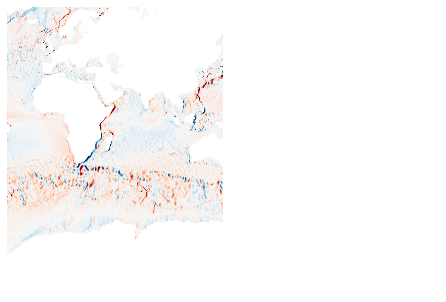

In [49]:
quick_llc_plot(V_mean, vmin=-0.5, vmax=0.5, 
               add_colorbar=False, axis_off=True,cmap='RdBu_r')
#plt.figure()
#plt.pcolormesh(mx.T,my.T,idw_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')
#plt.figure()
#plt.pcolormesh(mx.T,my.T,rbf_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')

In [57]:
idw_eta = idw_eta.reshape(mx.shape)
rbf_eta = rbf_eta.reshape(mx.shape)

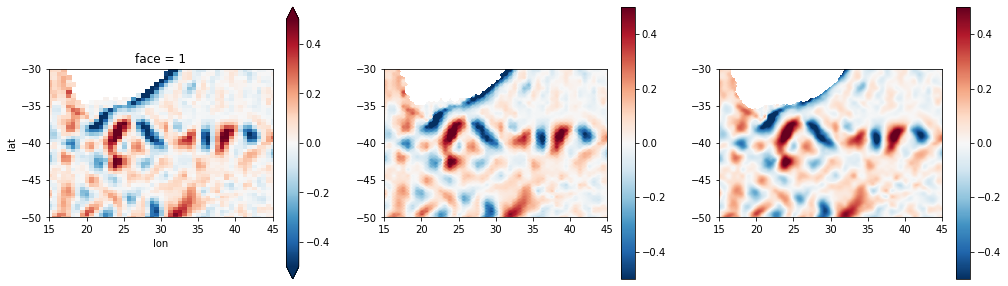

In [72]:
fig,axs = plt.subplots(1,3,figsize=(17,5))
V_mean.isel(face=1).isel(i=sli,j=sli).plot(x='lon',y='lat',vmin=-0.5,vmax=0.5,cmap='RdBu_r',ax=axs[0]
                                          )
cs = axs[1].pcolormesh(mx.T,my.T,idw_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')
plt.colorbar(cs,ax=axs[1])
axs[2].pcolormesh(mx.T,my.T,rbf_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')
plt.colorbar(cs,ax=axs[2])
for ax in axs:
    ax.set_ylim(-50,-30);ax.set_xlim(15,45)
    ax.set_aspect('equal')

### Load Lagrangian data

In [23]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
n_part = 377

df = dd.concat([df.get_partition(n) for n in range(0,n_part//2)])
#df = df.repartition(npartitions=n_part)
df = df.repartition(npartitions=105)
df = df.persist()

In [5]:
import pyinterp
def interp_trajectories(df_sub,v):
    grd = load_grd(V=['XC','YC','CS','SN'])
    if np.isin(v,['SSU','SSV']):
        ds = xr.merge([load_diagnostic("mean_"+V) for V in ['SSU','SSV']])
        ds = xr.merge([grd, ds])
        ds = ds.isel(i=slice(0,None, 2), j=slice(0,None, 2))
        U_mean =  ds.SSU.rename({'i_g':'i'})*ds.CS - ds.SSV.rename({'j_g':'j'})*ds.SN
        V_mean =  ds.SSU.rename({'i_g':'i'})*ds.SN + ds.SSV.rename({'j_g':'j'})*ds.CS
        ds['SSU'] = U_mean
        ds['SSV'] = V_mean
        ds = xr.merge([ds[V] for V in ['SSU','SSV']]).compute()
    else :
        ds = load_diagnostic("mean_"+v)
        ds = xr.merge([grd, ds])
        ds = ds.isel(i=slice(0,None, 2), j=slice(0,None, 2))
        ds = ds.compute()
        
    mesh = pyinterp.RTree()
    
    mesh.packing(np.vstack((ds.XC.values.flatten(), 
                            ds.YC.values.flatten())).T,
                 ds[v].values.flatten(),
                )
    
    idw_eta, neighbors = mesh.inverse_distance_weighting(
        np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
        within=True,
        radius=55000,
        k=8,  
        num_threads=0)
    
    df_sub[v+'_interp'] = idw_eta

    return  df_sub

### Interpolation over all trajectories : 

In [6]:
meta = {'trajectory':'int32','lat':'float64','lon':'float64','z':'float64','zonal_velocity':'float32','meridional_velocity':'float32','sea_level':'float32',
        'temperature':'float32','salinity':'float32'}

In [15]:
meta.update({'SSV'+'_interp':'float32'})

In [16]:
meta

{'trajectory': 'int32',
 'lat': 'float64',
 'lon': 'float64',
 'z': 'float64',
 'zonal_velocity': 'float32',
 'meridional_velocity': 'float32',
 'sea_level': 'float32',
 'temperature': 'float32',
 'salinity': 'float32',
 'SSU_interp': 'float32',
 'Eta_interp': 'float32',
 'SSV_interp': 'float32'}

In [33]:
v = 'SSU'
df_interp = df_interp.map_partitions(interp_trajectories,v).persist()
#meta.update({'SSV'+'_interp':'float32'})
#df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [ ]:
df = p.df['time']
df = dd.concat([df.get_partition(n) for n in range(n_part//2,n_part)])
df = df.repartition(npartitions=105)
df = df.persist()

In [ ]:
v = 'SSU'
df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [34]:
df_interp_bis.std().compute()

trajectory             2.029259e+07
lat                    3.856174e+01
lon                    1.063161e+02
z                      0.000000e+00
zonal_velocity         2.808537e-06
meridional_velocity    1.623439e-06
sea_level              1.122644e+00
temperature            1.208554e+01
salinity               1.427378e+00
SSU_interp             1.212575e-01
SSV_interp             6.575283e-02
Eta_interp             9.944422e-01
SSS_interp             9.681028e+23
SST_interp             1.197314e+01
dtype: float64

In [35]:
df_interp = df_interp.append(df_interp_bis).persist()

In [36]:
df_interp

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,SSU_interp,SSV_interp,Eta_interp,SSS_interp,SST_interp
npartitions=154,,,,,,,,,,,,,,
,int32,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
for v in ['SSV','Eta','SST','SSS']:
    df_interp = df_interp.map_partitions(interp_trajectories,v).persist()

In [ ]:
df_interp = df_interp.rename({'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity',
                              'Eta_interp':'mean_sea_level','SSS_interp':'mean_salinity','SST_interp':'mean_temperature'})

In [37]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_interp, overwrite=True, name="time_mean")

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/mean_interp
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/mean_interp


'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/mean_interp'

### Load interpolated dataframe

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['mean_interp'])
df = df = p.df['mean_interp']

df = pa.degs2ms(df) #Convert in m/s 
#df = df.repartition(npartitions=100)
df = df.persist()

### Visualization interpolation one trajectory : 

In [26]:
df_tst = df.groupby('trajectory').get_group(4000125).compute()


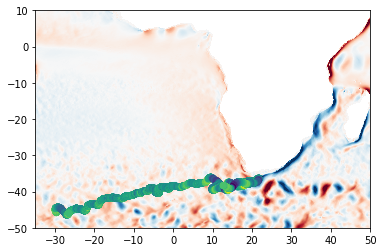

In [29]:
#Visualization trajectory with Eulerian mean field in the background

plt.pcolormesh(ds_mean['meridional_velocity_mean'].lon.isel(face=1),
               ds_mean['meridional_velocity_mean'].lat.isel(face=1),
               ds_mean['meridional_velocity_mean'].isel(face=1),cmap='RdBu_r',vmin=-0.5,vmax=0.5)
plt.ylim(-50,10);plt.xlim(-35,50)
plt.scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity)

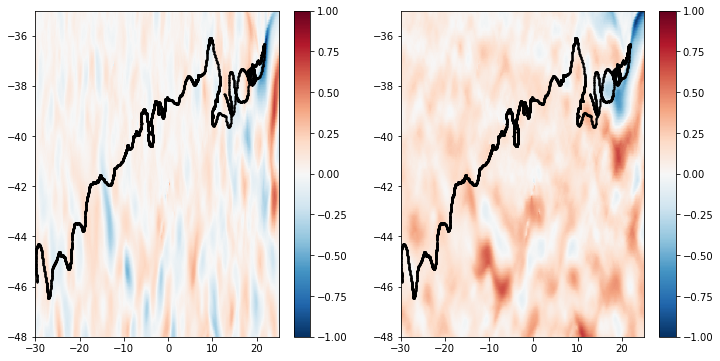

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].pcolormesh(ds.lon.isel(face=1),ds.lat.isel(face=1),V_mean.isel(face=1),cmap='RdBu_r',vmin=-1,vmax=1)
cs1 = ax[1].pcolormesh(ds.lon.isel(face=1),ds.lat.isel(face=1),U_mean.isel(face=1),cmap='RdBu_r',vmin=-1,vmax=1)
for a in ax:
    a.set_ylim(-48,-35);a.set_xlim(-30,25)
    a.scatter(df_tst.lon,df_tst.lat,s=1,c='k')
plt.colorbar(cs,ax=ax[0])
plt.colorbar(cs1,ax=ax[1])

#### Notes : 
One drifter trajectory with zonal (right) and meridional (left) velocities mean field in the background .

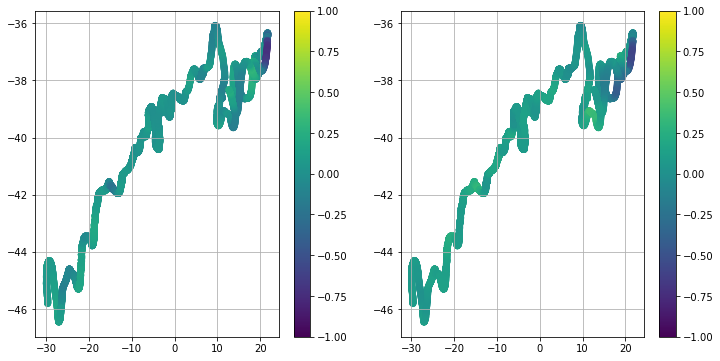

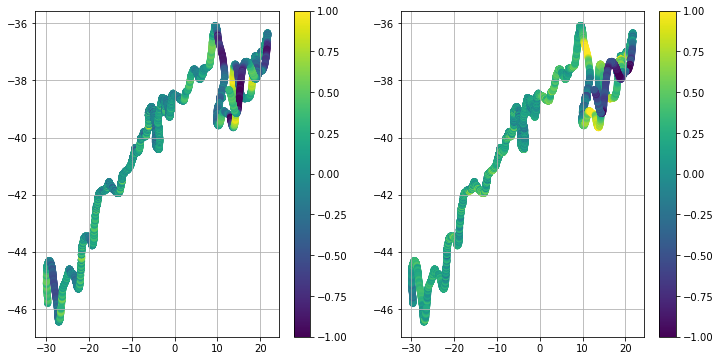

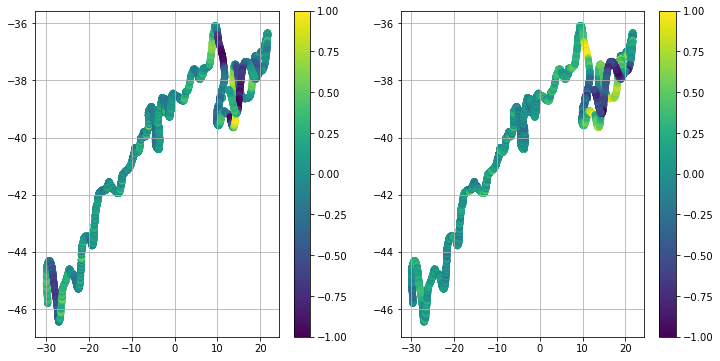

In [33]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.SSV_interp,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.SSU_interp,vmin=-1,vmax=1)
for a in ax:
    plt.colorbar(cs,ax=a)
    a.grid()
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.zonal_velocity,vmin=-1,vmax=1)
for a in ax:
    plt.colorbar(cs,ax=a)
    a.grid()
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity-df_tst.SSV_interp,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.zonal_velocity-df_tst.SSU_interp,vmin=-1,vmax=1)
for a in ax:
    plt.colorbar(cs,ax=a)
    a.grid()

Notes : 

First line : Eulerian mean field Interpolated over one drifter trajectory

Second line : Lagrangian velocity

Third line : Lagrangian velocity minus interpolated Eulerian mean field

### Visualization one partition : 

In [35]:
# Select 1 partition
df_part = df.get_partition(0).compute()


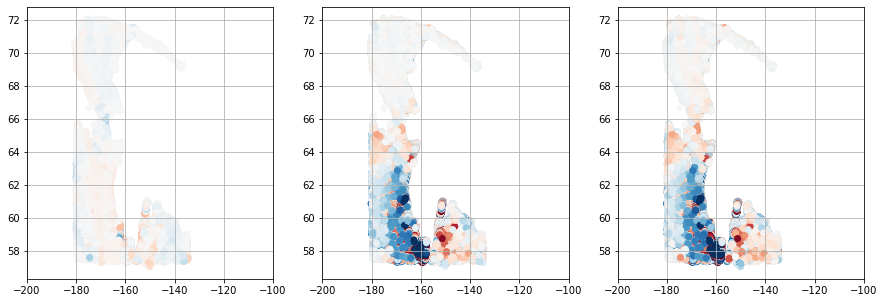

In [39]:
cmap= 'RdBu_r'

fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(df_part.lon,df_part.lat,c=df_part.SSU_interp,vmin=-1,vmax=1,cmap=cmap)
axs[0].set_xlim(-200,-100);axs[0].grid()

axs[1].scatter(df_part.lon,df_part.lat,c=df_part.zonal_velocity,vmin=-1,vmax=1,cmap=cmap)
axs[1].set_xlim(-200,-100);axs[1].grid()

axs[2].scatter(df_part.lon,df_part.lat,c=df_part.zonal_velocity-df_part.SSU_interp,vmin=-1,vmax=1,cmap=cmap)
axs[2].set_xlim(-200,-100);axs[2].grid()

#### Groupby means

In [4]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

In [5]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)

### Sub dataframe interpolated means and variables minus interpolated means

In [6]:
df = df.rename(columns={'SSU_interp':'zonal_velocity_interp','SSV_interp':'meridional_velocity_interp',
                        'Eta_interp':'sea_level_interp','SST_interp':'temperature_interp',
                       'SSS_interp':'salinity_interp'})

In [7]:
columns = df.columns[4:9]

for V in columns : 
    df[V] = df[V].sub(df[V+'_interp'])

In [8]:
# Add velocity amplitude in dataframe
df['velocity_amplitude'] = np.sqrt(df.zonal_velocity**2+df.meridional_velocity**2)
df['velocity_amplitude_interp'] = np.sqrt(df.zonal_velocity_interp**2+df.meridional_velocity_interp**2)

In [9]:
df = df.persist()

### Means computation

In [10]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [11]:
means = (df
         .groupby([df.lon_cut, df.lat_cut])
         .mean()
         .compute()
         #.to_frame()
        )



means = add_geodata(means)
#count['density'] = count['count']/count['area']

ds_mean = (means
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [12]:
std = (df
         .groupby([df.lon_cut, df.lat_cut])
         .std()
         .compute()
         #.to_frame()
        )



std = add_geodata(std)

ds_std = (std
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [13]:
ds_mean = ds_mean.rename({k :k+'_mean' for k in ds_mean.keys() })
ds_std = ds_std.rename({k :k+'_std' for k in ds_std.keys() })
ds_flts = xr.merge([ds_mean,ds_std])

In [23]:
count = (df
         .groupby([df.lon_cut, df.lat_cut])
         .count()
         .compute()
         #.to_frame()
        )

In [24]:
count = add_geodata(count)

ds_count = (count.drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [27]:
ds_count = ds_count.trajectory#.rename({'trajectory':'count'})

In [30]:
ds_count.name = 'count'

In [32]:
ds_flts = xr.merge([ds_flts,ds_count])

In [33]:
ds_flts

<xarray.Dataset>
Dimensions:                          (lat: 179, lon: 359)
Coordinates:
  * lon                              (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                              (lat) float64 -89.5 -88.5 ... 87.5 88.5
Data variables:
    zonal_velocity_mean              (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_mean         (lon, lat) float64 nan nan nan ... nan nan
    sea_level_mean                   (lon, lat) float64 nan nan nan ... nan nan
    temperature_mean                 (lon, lat) float64 nan nan nan ... nan nan
    salinity_mean                    (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_interp_mean       (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_interp_mean  (lon, lat) float64 nan nan nan ... nan nan
    sea_level_interp_mean            (lon, lat) float64 nan nan nan ... nan nan
    salinity_interp_mean             (lon, lat) float64 nan nan nan ... nan nan
    temperature_interp_mean          (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_mean          (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_interp_mean   (lon, lat) float64 nan nan nan ... nan nan
    area_mean                        (lon, lat) float64 nan 49.22 ... 28.8 49.22
    zonal_velocity_std               (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_std          (lon, lat) float64 nan nan nan ... nan nan
    sea_level_std                    (lon, lat) float64 nan nan nan ... nan nan
    temperature_std                  (lon, lat) float64 nan nan nan ... nan nan
    salinity_std                     (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_interp_std        (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_interp_std   (lon, lat) float64 nan nan nan ... nan nan
    sea_level_interp_std             (lon, lat) float64 nan nan nan ... nan nan
    salinity_interp_std              (lon, lat) float64 nan nan nan ... nan nan
    temperature_interp_std           (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_std           (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_interp_std    (lon, lat) float64 nan nan nan ... nan nan
    area_std                         (lon, lat) float64 nan 49.22 ... 28.8 49.22
    count                            (lon, lat) float64 0.0 0.0 0.0 ... 0.0 0.0

### Visualization

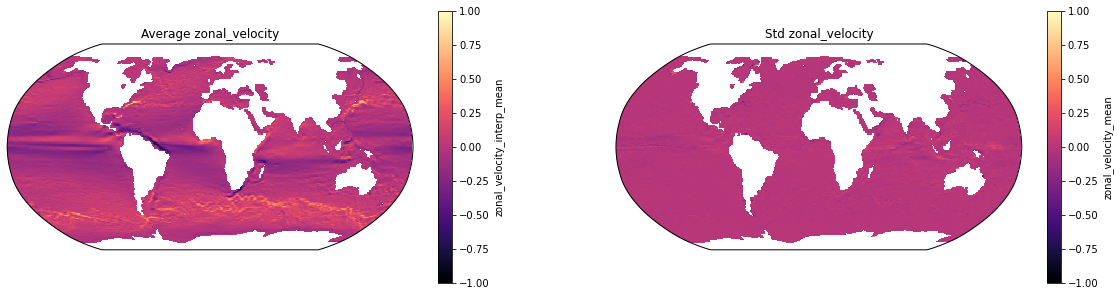

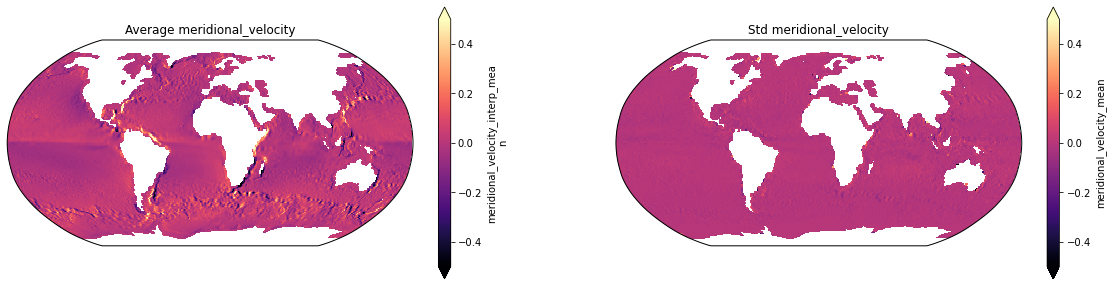

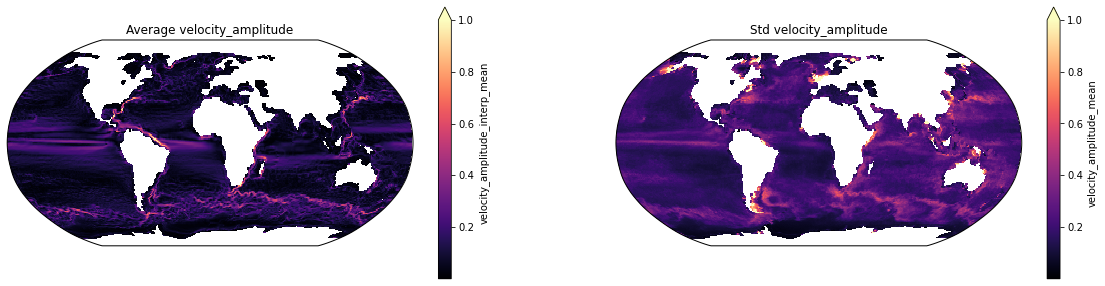

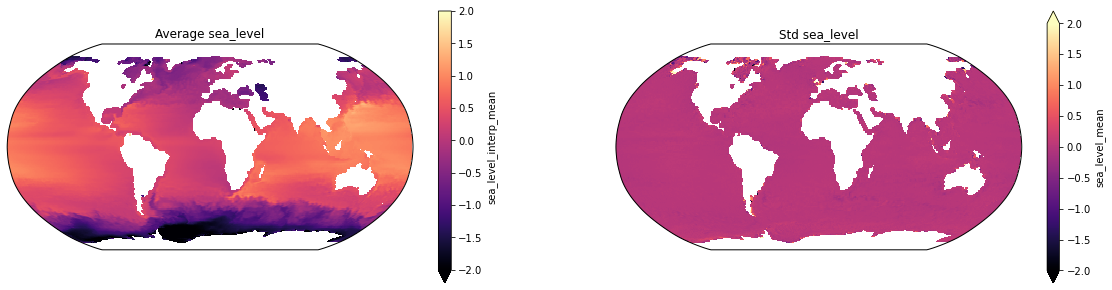

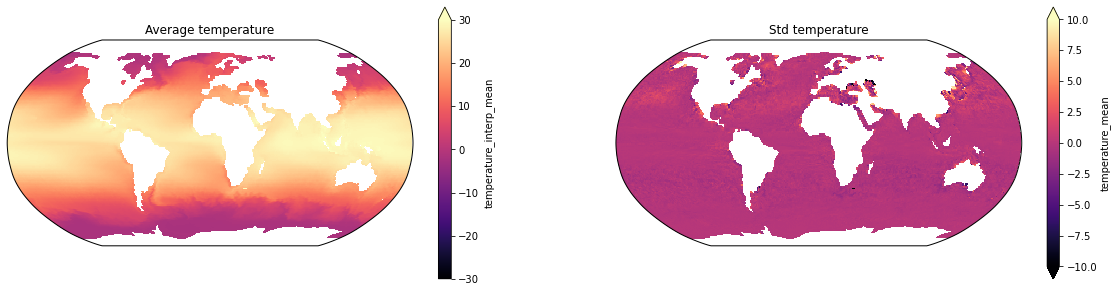

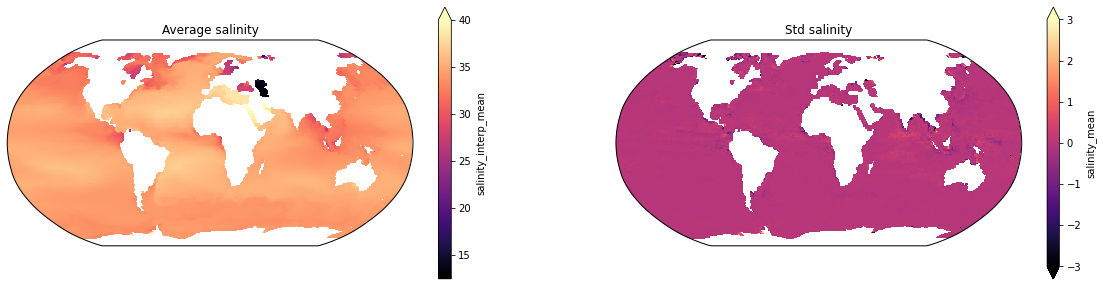

In [16]:
for V,vmax in zip(['zonal_velocity', 'meridional_velocity','velocity_amplitude','sea_level','temperature','salinity'],[[1,1],[0.5,0.5],[1,1],[2,2],[30,10],[40,3]]):
    figsize = (20,5)

    #crs = ccrs.Mollweide()
    crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection=crs)

    ds_flts[V+'_interp'+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[0],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Average '+V)
    ax = fig.add_subplot(122, projection=crs)

    ds_flts[V+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[1],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Std '+V)

In [21]:
# Drop useless columns
ds_flts = ds_flts.drop(['z_mean','z_std','trajectory_mean','trajectory_std'])

In [34]:
#store dataset in diagnostics directory
p.store_diagnostic("Linterp_mean_std_dl1", ds_flts,overwrite=True)

Linterp_mean_std_dl1 diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/Linterp_mean_std_dl1.zarr


In [73]:
cluster.close()